In [20]:
# Cell 1: Imports and Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import os
import logging
import datetime as dt # For type hinting if needed

# --- Logging Setup ---
logger_eda_live = logging.getLogger("eda_live_backtest_logs")
if not logger_eda_live.handlers:
    logger_eda_live.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(name)s - %(message)s')
    ch = logging.StreamHandler()
    ch.setFormatter(formatter)
    logger_eda_live.addHandler(ch)
else:
    for handler in logger_eda_live.handlers[:]: logger_eda_live.removeHandler(handler)
    logger_eda_live.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(name)s - %(message)s')
    ch = logging.StreamHandler()
    ch.setFormatter(formatter)
    logger_eda_live.addHandler(ch)

# --- Directories ---
BASE_PROJECT_DIR = Path("/Users/omarabul-hassan/Desktop/projects/kalshi") 
RANDOM_DIR = BASE_PROJECT_DIR / "random"
LIVE_BACKTEST_LOG_DIR_BASE = RANDOM_DIR / "backtest" / "logs" 

# --- Import Live Backtest Configuration ---
# This assumes live_backtest_config.py is in ../backtest/ relative to this EDA notebook's location (random/eda/)
# Adjust path if necessary, or ensure PYTHONPATH is set up if it's in a non-standard location.
import sys
live_backtest_dir = RANDOM_DIR / "backtest"
if str(live_backtest_dir) not in sys.path:
    sys.path.insert(0, str(live_backtest_dir))
import live_backtest_config as live_cfg # <<<<<<<<<<< IMPORT ADDED HERE

# --- Plotting Style ---
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")
# For better plot rendering in Jupyter
%matplotlib inline 
# %config InlineBackend.figure_format = 'retina' # Optional: for higher res plots

logger_eda_live.info(f"Trade logs expected from subdirectories in: {LIVE_BACKTEST_LOG_DIR_BASE}")
logger_eda_live.info(f"Live backtest config loaded. KELLY_FRACTION: {live_cfg.KELLY_FRACTION if hasattr(live_cfg, 'KELLY_FRACTION') else 'Not Found'}") # Test
logger_eda_live.info("EDA Setup for Live Backtest (Hourly Logs) complete.")

2025-05-23 16:00:19,740 - INFO - live_backtest_config - Live Kalshi data dir: /Users/omarabul-hassan/Desktop/projects/kalshi/random/market_data_logs
2025-05-23 16:00:19,741 - INFO - live_backtest_config - Live Binance data dir: /Users/omarabul-hassan/Desktop/projects/kalshi/random/binance_market_data_logs
2025-05-23 16:00:19,741 - INFO - live_backtest_config - Live market outcomes CSV: /Users/omarabul-hassan/Desktop/projects/kalshi/random/backtest/live_sessions_market_outcomes.csv
2025-05-23 16:00:19,741 - INFO - live_backtest_config - Using model from directory: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/trained_models/logreg_per_minute_no_vol_oi
2025-05-23 16:00:19,742 - INFO - live_backtest_config - Model path: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/trained_models/logreg_per_minute_no_vol_oi/logreg_per_minute_no_vol_oi_model.joblib
2025-05-23 16:00:19,742 - INFO - live_backtest_config - Scaler path: /Users/omarabul-hassan/Desktop/projects/kalshi/noteb

In [21]:
# Cell 2: Load and Consolidate Trade Logs (Updated for Hourly Structure)

all_trades_df = pd.DataFrame() 

if not LIVE_BACKTEST_LOG_DIR_BASE.exists():
    logger_eda_live.error(f"Live trade log base directory not found: {LIVE_BACKTEST_LOG_DIR_BASE}")
else:
    # Option 1: Load the consolidated summary file if it exists and is preferred
    summary_log_files = sorted(list(LIVE_BACKTEST_LOG_DIR_BASE.glob("all_live_trades_summary_kelly_*.csv")), key=os.path.getctime, reverse=True) # Match Kelly summary
    if summary_log_files:
        latest_summary_log = summary_log_files[0]
        logger_eda_live.info(f"Loading consolidated trade log: {latest_summary_log.name}")
        try:
            all_trades_df = pd.read_csv(latest_summary_log)
            if all_trades_df.empty:
                 logger_eda_live.warning(f"Consolidated log file {latest_summary_log.name} is empty. Will try hourly files.")
        except Exception as e:
            logger_eda_live.error(f"Error reading consolidated log file {latest_summary_log.name}: {e}. Will try hourly files.")
            all_trades_df = pd.DataFrame() 

    # Option 2: Fallback to loading hourly files if summary wasn't loaded or was empty
    if all_trades_df.empty:
        logger_eda_live.info("Consolidated summary not loaded or empty, trying hourly *_live_trades.csv files...")
        # Glob for any CSV file within any date subdirectory (YYYY-MM-DD/*_live_trades.csv)
        hourly_log_files = sorted(list(LIVE_BACKTEST_LOG_DIR_BASE.glob("*/*_live_trades.csv")))
        
        if not hourly_log_files:
            logger_eda_live.warning(f"No hourly live trade log CSV files found in subdirectories of {LIVE_BACKTEST_LOG_DIR_BASE}.")
        else:
            logger_eda_live.info(f"Found {len(hourly_log_files)} hourly live trade log files. Consolidating...")
            df_list = []
            for log_file in hourly_log_files:
                try:
                    hourly_df = pd.read_csv(log_file)
                    if not hourly_df.empty:
                        # Extract date and hour from filepath for verification or grouping
                        hourly_df['log_file_date_str'] = log_file.parent.name # YYYY-MM-DD
                        hourly_df['log_file_hour_str'] = log_file.stem.split('_live_trades')[0] # HH
                        df_list.append(hourly_df)
                    else:
                        logger_eda_live.info(f"Hourly log file {log_file.name} in {log_file.parent.name} is empty.")
                except pd.errors.EmptyDataError:
                     logger_eda_live.warning(f"Log file {log_file.name} in {log_file.parent.name} is empty (pandas parse error).")
                except Exception as e:
                    logger_eda_live.error(f"Error reading hourly log file {log_file.name} in {log_file.parent.name}: {e}")
            
            if df_list:
                all_trades_df = pd.concat(df_list, ignore_index=True)
            else:
                 logger_eda_live.warning("No data loaded from hourly log files either.")


if not all_trades_df.empty:
    logger_eda_live.info(f"Consolidated {len(all_trades_df)} trades.")
    
    all_trades_df['trade_execution_time_utc'] = pd.to_datetime(all_trades_df['trade_execution_time_utc'])
    
    # Define all expected numeric columns, including Kelly ones
    numeric_cols = [
        'strike_price', 'resolution_time_ts', 'decision_timestamp_s', 
        'time_to_resolution_minutes', 'predicted_prob_yes', 
        'bet_cost_cents_per_contract', 'contracts_traded', 
        'actual_outcome_target', 'pnl_cents',
        'current_capital_before_trade_cents', 'kelly_fraction_f_star',
        'capital_to_risk_cents', 'trade_value_cents'
    ]
    for col in numeric_cols:
        if col in all_trades_df.columns:
            all_trades_df[col] = pd.to_numeric(all_trades_df[col], errors='coerce')
    
    all_trades_df.sort_values(by='trade_execution_time_utc', inplace=True)
    all_trades_df.reset_index(drop=True, inplace=True)

    logger_eda_live.info("Data types converted and trades sorted.")
    print("Sample of loaded trades:")
    display(all_trades_df.head())
    print("\nInfo of loaded trades DataFrame:")
    all_trades_df.info()
else:
    logger_eda_live.warning("No trade data loaded for analysis.")

2025-05-23 16:00:19,760 - INFO - eda_live_backtest_logs - Loading consolidated trade log: all_live_trades_summary_kelly_20250523_152304.csv
2025-05-23 16:00:19,760 - INFO - eda_live_backtest_logs - Loading consolidated trade log: all_live_trades_summary_kelly_20250523_152304.csv
2025-05-23 16:00:19,765 - INFO - eda_live_backtest_logs - Consolidated 295 trades.
2025-05-23 16:00:19,765 - INFO - eda_live_backtest_logs - Consolidated 295 trades.
2025-05-23 16:00:19,768 - INFO - eda_live_backtest_logs - Data types converted and trades sorted.
2025-05-23 16:00:19,768 - INFO - eda_live_backtest_logs - Data types converted and trades sorted.


Sample of loaded trades:


,trade_execution_time_utc,market_ticker,strike_price,resolution_time_ts,decision_timestamp_s,time_to_resolution_minutes,action,predicted_prob_yes,bet_cost_cents_per_contract,contracts_traded,actual_outcome_target,pnl_cents,current_capital_before_trade_cents,kelly_fraction_f_star,capital_to_risk_cents,trade_value_cents
0,2025-05-19 23:36:00+00:00,KXBTCD-25MAY1920-T105999.99,105999.99,1747699200,1747697760,24.0,BUY_NO,0.0776,92,8,0,64,50000,0.0296,739,736
1,2025-05-19 23:38:00+00:00,KXBTCD-25MAY1920-T105999.99,105999.99,1747699200,1747697880,22.0,BUY_NO,0.0661,93,15,0,105,50064,0.0558,1398,1395
2,2025-05-19 23:39:00+00:00,KXBTCD-25MAY1920-T105999.99,105999.99,1747699200,1747697940,21.0,BUY_NO,0.0665,93,13,0,91,50169,0.0500,1254,1209
3,2025-05-19 23:40:00+00:00,KXBTCD-25MAY1920-T105999.99,105999.99,1747699200,1747698000,20.0,BUY_NO,0.0660,93,15,0,105,50260,0.0570,1432,1395
4,2025-05-19 23:45:00+00:00,KXBTCD-25MAY1920-T105499.99,105499.99,1747699200,1747698300,15.0,BUY_YES,0.9346,93,17,1,119,50365,0.0663,1670,1581



Info of loaded trades DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   trade_execution_time_utc            295 non-null    datetime64[ns, UTC]
 1   market_ticker                       295 non-null    object             
 2   strike_price                        295 non-null    float64            
 3   resolution_time_ts                  295 non-null    int64              
 4   decision_timestamp_s                295 non-null    int64              
 5   time_to_resolution_minutes          295 non-null    float64            
 6   action                              295 non-null    object             
 7   predicted_prob_yes                  295 non-null    float64            
 8   bet_cost_cents_per_contract         295 non-null    int64              
 9   contracts

In [22]:
# Cell 3: Overall Performance Metrics (Updated for Kelly)

if not all_trades_df.empty:
    # P&L based on simple sum of pnl_cents per trade (ignoring Kelly impact on capital for this metric)
    total_simple_pnl_cents = all_trades_df['pnl_cents'].sum() 
    
    total_trades = len(all_trades_df) # Number of trade decisions that led to a bet
    total_contracts_traded = all_trades_df['contracts_traded'].sum()

    # Win/Loss based on P&L of the trade decision
    wins = all_trades_df[all_trades_df['pnl_cents'] > 0]
    losses = all_trades_df[all_trades_df['pnl_cents'] < 0]
    num_winning_trades = len(wins)
    num_losing_trades = len(losses)
    num_scratch_trades = total_trades - num_winning_trades - num_losing_trades
    
    win_rate_trades = num_winning_trades / total_trades if total_trades > 0 else 0
    
    avg_pnl_per_trade_cents = all_trades_df['pnl_cents'].mean() if total_trades > 0 else 0
    avg_contracts_per_trade = all_trades_df['contracts_traded'].mean() if total_trades > 0 else 0
    
    avg_win_cents = wins['pnl_cents'].sum() / wins['contracts_traded'].sum() if not wins.empty and wins['contracts_traded'].sum() > 0 else 0
    avg_loss_cents = losses['pnl_cents'].sum() / losses['contracts_traded'].sum() if not losses.empty and losses['contracts_traded'].sum() > 0 else 0

    total_gross_profit_cents = wins['pnl_cents'].sum()
    total_gross_loss_cents = losses['pnl_cents'].sum() 

    profit_factor = np.inf
    if total_gross_loss_cents != 0:
        profit_factor = total_gross_profit_cents / abs(total_gross_loss_cents)

    logger_eda_live.info("--- Overall Live Backtest Performance (with Kelly Sizing if used) ---")
    
    summary_metrics = {
        "Total Trade Decisions Made": total_trades,
        "Total Contracts Traded": total_contracts_traded,
        "Total P&L (Simple Sum, USD)": f"{total_simple_pnl_cents / 100:.2f}",
        "Number of Winning Trade Decisions": num_winning_trades,
        "Number of Losing Trade Decisions": num_losing_trades,
        "Number of Scratch Trade Decisions": num_scratch_trades,
        "Win Rate (by Trade Decision)": f"{win_rate_trades:.2%}",
        "Average P&L per Trade Decision (USD)": f"{avg_pnl_per_trade_cents / 100:.4f}",
        "Average Contracts per Trade Decision": f"{avg_contracts_per_trade:.2f}",
        "Average Win per Contract (USD)": f"{avg_win_cents / 100:.4f}", # Changed from per trade to per contract
        "Average Loss per Contract (USD)": f"{avg_loss_cents / 100:.4f}", # Changed from per trade to per contract
        "Total Gross Profit (USD)": f"{total_gross_profit_cents / 100:.2f}",
        "Total Gross Loss (USD)": f"{total_gross_loss_cents / 100:.2f}", # This sum is negative
        "Profit Factor": f"{profit_factor:.2f}"
    }

    # Kelly Specific Metrics if columns exist
    if 'current_capital_before_trade_cents' in all_trades_df.columns and not all_trades_df.empty:
        initial_capital_kelly = all_trades_df['current_capital_before_trade_cents'].iloc[0]
        final_capital_kelly = all_trades_df['current_capital_before_trade_cents'].iloc[-1] + all_trades_df['pnl_cents'].iloc[-1] # Capital after last trade
        
        summary_metrics["Initial Capital (Kelly, USD)"] = f"{initial_capital_kelly / 100:.2f}"
        summary_metrics["Final Capital (Kelly, USD)"] = f"{final_capital_kelly / 100:.2f}"
        kelly_pnl_usd = (final_capital_kelly - initial_capital_kelly) / 100.0
        summary_metrics["Total P&L (Kelly Capital Change, USD)"] = f"{kelly_pnl_usd:.2f}"
        if initial_capital_kelly > 0 :
             kelly_return_pct = (kelly_pnl_usd / (initial_capital_kelly/100.0)) * 100
             summary_metrics["Return on Initial Capital (Kelly, %)"] = f"{kelly_return_pct:.2f}%"
    
    summary_df = pd.DataFrame(list(summary_metrics.items()), columns=["Metric", "Value"])
    print("Overall Performance Summary:")
    display(summary_df)
    
else:
    logger_eda_live.warning("all_trades_df is empty. Cannot calculate overall performance.")

2025-05-23 16:00:19,968 - INFO - eda_live_backtest_logs - --- Overall Live Backtest Performance (with Kelly Sizing if used) ---
2025-05-23 16:00:19,968 - INFO - eda_live_backtest_logs - --- Overall Live Backtest Performance (with Kelly Sizing if used) ---


Overall Performance Summary:


,Metric,Value
0,Total Trade Decisions Made,295
1,Total Contracts Traded,4333
2,"Total P&L (Simple Sum, USD)",212.98
3,Number of Winning Trade Decisions,292
4,Number of Losing Trade Decisions,3
5,Number of Scratch Trade Decisions,0
6,Win Rate (by Trade Decision),98.98%
7,Average P&L per Trade Decision (USD),0.7220
8,Average Contracts per Trade Decision,14.69
9,Average Win per Contract (USD),0.0552


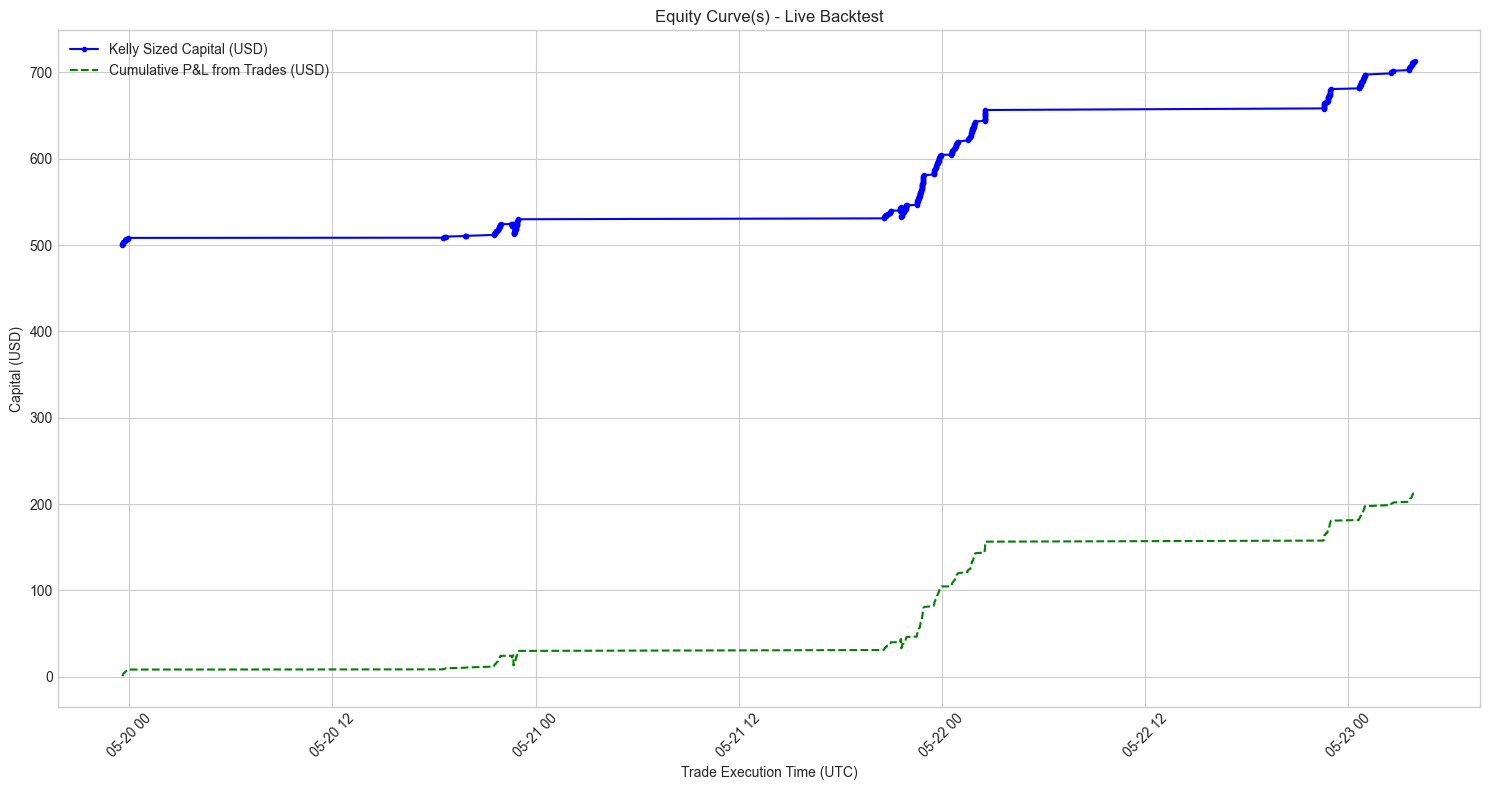

In [23]:
# Cell 4: P&L Over Time (Equity Curve - Kelly & Simple)

if not all_trades_df.empty and 'pnl_cents' in all_trades_df.columns and 'trade_execution_time_utc' in all_trades_df.columns:
    all_trades_df['pnl_cents'] = pd.to_numeric(all_trades_df['pnl_cents'], errors='coerce').fillna(0)

    # Simple Cumulative P&L (sum of P&L from each trade, as if 1 contract fixed size for this plot)
    all_trades_df['simple_cumulative_pnl_cents'] = all_trades_df['pnl_cents'].cumsum() # This is actually already Kelly-sized P&L sum

    plt.figure(figsize=(15, 8))
    
    # Plot 1: Kelly Capital Curve (if Kelly was used)
    if 'current_capital_before_trade_cents' in all_trades_df.columns and 'pnl_cents' in all_trades_df.columns:
        # Reconstruct capital after each trade for plotting
        all_trades_df['capital_after_trade_cents'] = all_trades_df['current_capital_before_trade_cents'] + all_trades_df['pnl_cents']
        # Plot initial capital as the first point
        initial_capital_plot = pd.DataFrame({
            'trade_execution_time_utc': [all_trades_df['trade_execution_time_utc'].min() - pd.Timedelta(seconds=1)],
            'capital_after_trade_cents': [all_trades_df['current_capital_before_trade_cents'].iloc[0]]
        })
        plot_df_kelly = pd.concat([initial_capital_plot, all_trades_df[['trade_execution_time_utc', 'capital_after_trade_cents']]], ignore_index=True)
        
        plt.plot(plot_df_kelly['trade_execution_time_utc'], 
                 plot_df_kelly['capital_after_trade_cents'] / 100.0, 
                 label='Kelly Sized Capital (USD)', color='blue', marker='.', linestyle='-')
        plt.ylabel('Capital (USD)')
        
    # Plot 2: Cumulative P&L (sum of pnl_cents from trades) - this reflects Kelly sizing if used
    # If you want a true "1-contract equivalent" P&L curve, you'd need to re-calculate P&L as if contracts_traded was always 1.
    # For now, this `simple_cumulative_pnl_cents` IS the Kelly-sized P&L accumulation.
    plt.plot(all_trades_df['trade_execution_time_utc'], 
             all_trades_df['simple_cumulative_pnl_cents'] / 100.0, 
             label='Cumulative P&L from Trades (USD)', color='green', linestyle='--')
    if 'current_capital_before_trade_cents' not in all_trades_df.columns: # Only label Y this if no Kelly plot
        plt.ylabel('Cumulative P&L (USD)')


    plt.title('Equity Curve(s) - Live Backtest')
    plt.xlabel('Trade Execution Time (UTC)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()
else:
    logger_eda_live.warning("Cannot plot equity curve: DataFrame empty or required columns missing.")

2025-05-23 16:00:20,057 - INFO - eda_live_backtest_logs - 
--- Daily Performance (Live Backtest) ---
2025-05-23 16:00:20,057 - INFO - eda_live_backtest_logs - 
--- Daily Performance (Live Backtest) ---


Daily Performance Summary:


,decision_date,total_trades_daily,total_contracts_daily,total_pnl_usd_daily,win_rate_daily
0,2025-05-19,10,139,8.26,1.000000
1,2025-05-20,56,683,21.60,0.964286
2,2025-05-21,105,1581,74.60,0.990476
3,2025-05-22,86,1372,76.22,1.000000
4,2025-05-23,38,558,32.30,1.000000


2025-05-23 16:00:20,063 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 16:00:20,064 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


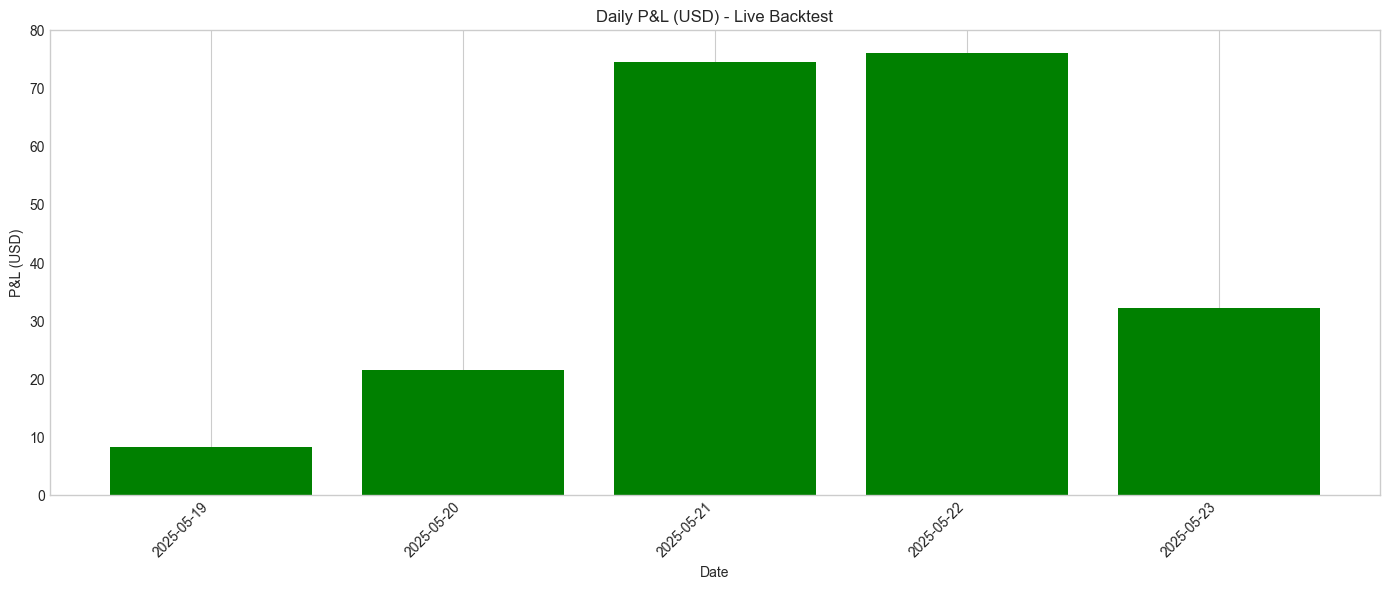

2025-05-23 16:00:20,105 - INFO - eda_live_backtest_logs - 
--- Hourly Performance (Aggregated Across All Days) ---
2025-05-23 16:00:20,105 - INFO - eda_live_backtest_logs - 
--- Hourly Performance (Aggregated Across All Days) ---


Hourly Performance Summary (UTC Hours):


,decision_hour_utc,total_trades_hourly,total_contracts_hourly,total_pnl_usd_hourly,win_rate_hourly
0,0,40,545,32.16,1.00000
1,1,25,415,23.13,1.00000
2,2,17,355,17.79,1.00000
3,3,14,177,11.16,1.00000
4,18,4,21,1.54,1.00000
5,19,3,21,0.84,1.00000
6,20,16,134,10.03,1.00000
7,21,41,505,19.70,0.97561
8,22,100,1601,64.71,0.98000
9,23,35,559,31.92,1.00000


2025-05-23 16:00:20,111 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/43/br9zl9l149d3rb94gdkr1wsm0000gn/T/ipykernel_6469/3544071584.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hourly_performance, x='decision_hour_utc', y='total_pnl_usd_hourly',
/var/folders/43/br9zl9l149d3rb94gdkr1wsm0000gn/T/ipykernel_6469/3544071584.py:50: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=hourly_performance, x='decision_hour_utc', y='total_pnl_usd_hourly',
2025-05-23 16:00:20,113 - INFO - matplotlib.category - Using categorical units to plot a list 

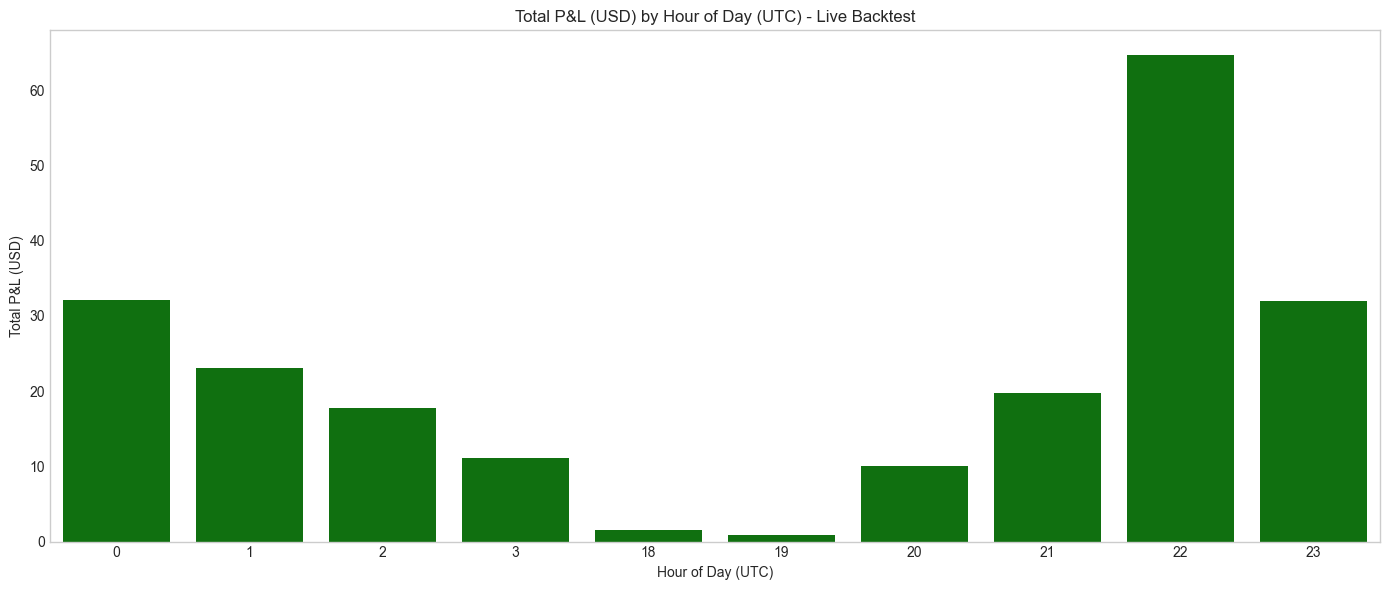

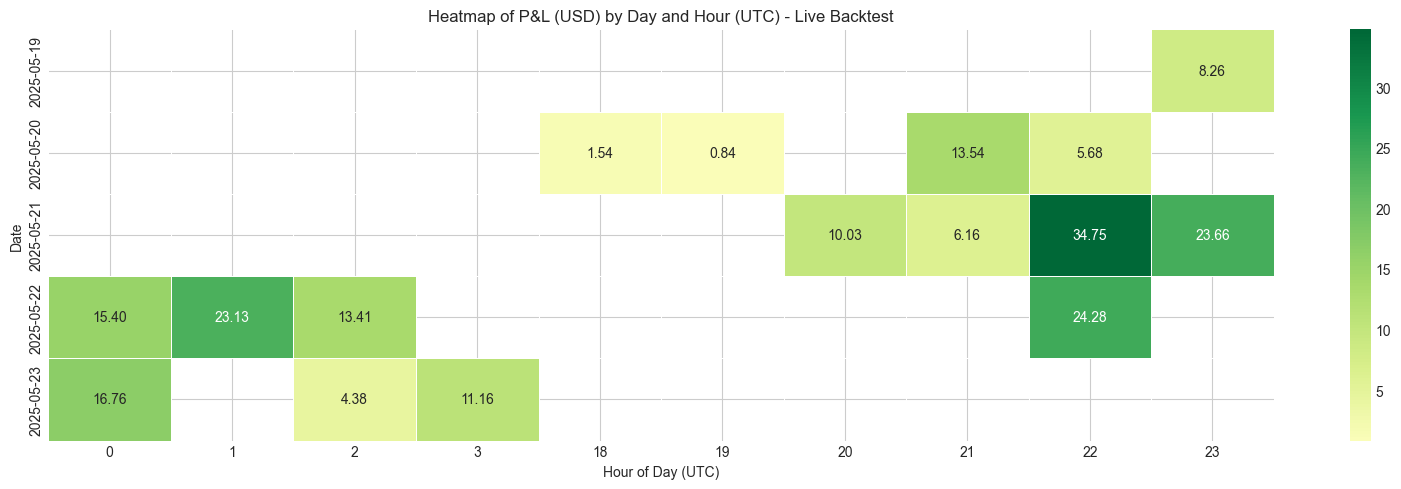

In [24]:
# Cell 5: Performance by Day and Hour

if not all_trades_df.empty and 'trade_execution_time_utc' in all_trades_df.columns:
    all_trades_df['decision_date'] = all_trades_df['trade_execution_time_utc'].dt.date
    all_trades_df['decision_hour_utc'] = all_trades_df['trade_execution_time_utc'].dt.hour
    
    # --- Daily Performance ---
    daily_performance = all_trades_df.groupby('decision_date').agg(
        total_trades_daily=('market_ticker', 'count'),
        total_contracts_daily=('contracts_traded', 'sum'),
        total_pnl_cents_daily=('pnl_cents', 'sum'),
        win_trades_daily=('pnl_cents', lambda x: (x > 0).sum())
    ).reset_index()
    
    daily_performance['win_rate_daily'] = daily_performance.apply(
        lambda row: row['win_trades_daily'] / row['total_trades_daily'] if row['total_trades_daily'] > 0 else 0, axis=1
    )
    daily_performance['total_pnl_usd_daily'] = daily_performance['total_pnl_cents_daily'] / 100.0
    
    logger_eda_live.info("\n--- Daily Performance (Live Backtest) ---")
    print("Daily Performance Summary:")
    display(daily_performance[['decision_date', 'total_trades_daily', 'total_contracts_daily', 'total_pnl_usd_daily', 'win_rate_daily']])
    
    plt.figure(figsize=(14, 6))
    plt.bar(daily_performance['decision_date'].astype(str), daily_performance['total_pnl_usd_daily'], 
            color=np.where(daily_performance['total_pnl_usd_daily'] >= 0, 'g', 'r'))
    plt.title('Daily P&L (USD) - Live Backtest')
    plt.xlabel('Date'); plt.ylabel('P&L (USD)'); plt.xticks(rotation=45, ha='right')
    plt.tight_layout(); plt.grid(axis='y'); plt.show()

    # --- Hourly Performance (Overall) ---
    hourly_performance = all_trades_df.groupby('decision_hour_utc').agg(
        total_trades_hourly=('market_ticker', 'count'),
        total_contracts_hourly=('contracts_traded', 'sum'),
        total_pnl_cents_hourly=('pnl_cents', 'sum'),
        win_trades_hourly=('pnl_cents', lambda x: (x > 0).sum())
    ).reset_index()

    hourly_performance['win_rate_hourly'] = hourly_performance.apply(
        lambda row: row['win_trades_hourly'] / row['total_trades_hourly'] if row['total_trades_hourly'] > 0 else 0, axis=1
    )
    hourly_performance['total_pnl_usd_hourly'] = hourly_performance['total_pnl_cents_hourly'] / 100.0
    hourly_performance.sort_values(by='decision_hour_utc', inplace=True)

    logger_eda_live.info("\n--- Hourly Performance (Aggregated Across All Days) ---")
    print("Hourly Performance Summary (UTC Hours):")
    display(hourly_performance[['decision_hour_utc', 'total_trades_hourly', 'total_contracts_hourly', 'total_pnl_usd_hourly', 'win_rate_hourly']])

    plt.figure(figsize=(14, 6))
    sns.barplot(data=hourly_performance, x='decision_hour_utc', y='total_pnl_usd_hourly', 
                palette=np.where(hourly_performance['total_pnl_usd_hourly'] >= 0, 'g', 'r'))
    plt.title('Total P&L (USD) by Hour of Day (UTC) - Live Backtest')
    plt.xlabel('Hour of Day (UTC)'); plt.ylabel('Total P&L (USD)')
    plt.tight_layout(); plt.grid(axis='y'); plt.show()

    # --- Heatmap of P&L by Day and Hour ---
    day_hour_performance = all_trades_df.groupby(['decision_date', 'decision_hour_utc']).agg(
        total_pnl_cents=('pnl_cents', 'sum')
    ).reset_index()
    day_hour_performance['total_pnl_usd'] = day_hour_performance['total_pnl_cents'] / 100.0
    
    if not day_hour_performance.empty:
        heatmap_data = day_hour_performance.pivot_table(index='decision_date', columns='decision_hour_utc', values='total_pnl_usd')
        plt.figure(figsize=(16, max(5, len(heatmap_data.index)*0.5) )) # Adjust height based on number of days
        sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="RdYlGn", center=0, linewidths=.5)
        plt.title('Heatmap of P&L (USD) by Day and Hour (UTC) - Live Backtest')
        plt.xlabel('Hour of Day (UTC)'); plt.ylabel('Date')
        plt.tight_layout(); plt.show()
    else:
        logger_eda_live.info("Not enough data for day-hour heatmap.")
        
else:
    logger_eda_live.warning("Cannot analyze daily/hourly performance: DataFrame empty or 'trade_execution_time_utc' missing.")

In [25]:
# Cell 6: Analysis by Trade Action (BUY_YES vs BUY_NO) (Updated for Contracts)

if not all_trades_df.empty and 'action' in all_trades_df.columns:
    action_performance = all_trades_df.groupby('action').agg(
        num_trades=('market_ticker', 'size'), # Number of trade decisions
        total_contracts_traded=('contracts_traded', 'sum'),
        total_pnl_cents=('pnl_cents', 'sum'),
        avg_pnl_per_trade_cents=('pnl_cents', 'mean'), # Avg P&L per trade decision
        win_trade_decisions=('pnl_cents', lambda x: (x > 0).sum())
    ).reset_index()
    
    action_performance['win_rate_by_decision'] = action_performance.apply(
        lambda row: row['win_trade_decisions'] / row['num_trades'] if row['num_trades'] > 0 else 0, axis=1
    )
    action_performance['total_pnl_usd'] = action_performance['total_pnl_cents'] / 100.0
    action_performance['avg_pnl_per_trade_usd'] = action_performance['avg_pnl_per_trade_cents'] / 100.0
    # Avg P&L per contract traded for this action
    action_performance['avg_pnl_per_contract_usd'] = action_performance.apply(
        lambda row: (row['total_pnl_cents'] / row['total_contracts_traded'] / 100.0) if row['total_contracts_traded'] > 0 else 0, axis=1
    )
    
    logger_eda_live.info("\n--- Performance by Trade Action (Live Backtest) ---")
    print("Performance by Trade Action:")
    display(action_performance[['action', 'num_trades', 'total_contracts_traded', 'total_pnl_usd', 
                                'avg_pnl_per_trade_usd', 'avg_pnl_per_contract_usd', 'win_rate_by_decision']])
else:
    logger_eda_live.warning("Cannot analyze by trade action: DataFrame empty or 'action' column missing.")

2025-05-23 16:00:20,247 - INFO - eda_live_backtest_logs - 
--- Performance by Trade Action (Live Backtest) ---
2025-05-23 16:00:20,247 - INFO - eda_live_backtest_logs - 
--- Performance by Trade Action (Live Backtest) ---


Performance by Trade Action:


,action,num_trades,total_contracts_traded,total_pnl_usd,avg_pnl_per_trade_usd,avg_pnl_per_contract_usd,win_rate_by_decision
0,BUY_NO,86,830,36.95,0.429651,0.044518,0.965116
1,BUY_YES,209,3503,176.03,0.842249,0.050251,1.000000


2025-05-23 16:00:20,258 - INFO - eda_live_backtest_logs - 
--- Predicted Probability Analysis (Live Backtest) ---
2025-05-23 16:00:20,258 - INFO - eda_live_backtest_logs - 
--- Predicted Probability Analysis (Live Backtest) ---


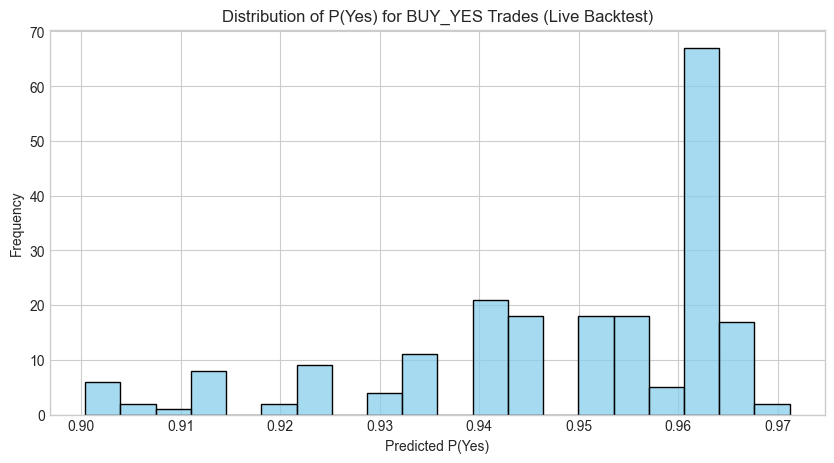

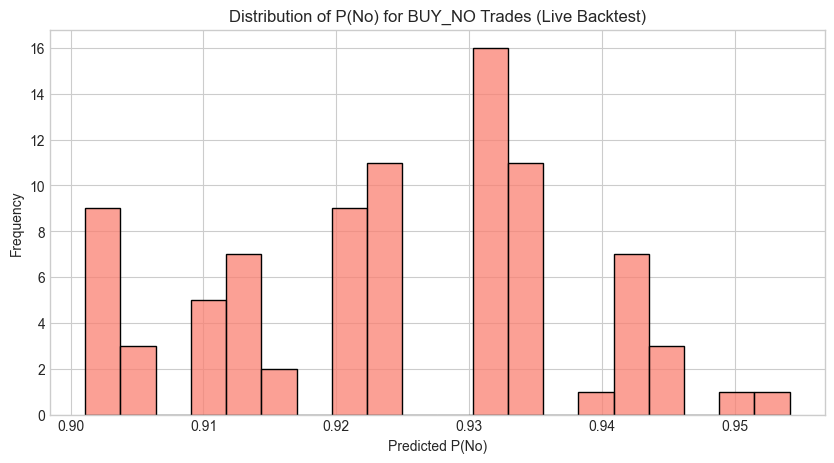

2025-05-23 16:00:20,358 - INFO - eda_live_backtest_logs - 
--- Analysis by Binned Model Confidence (Live Backtest) ---
2025-05-23 16:00:20,358 - INFO - eda_live_backtest_logs - 
--- Analysis by Binned Model Confidence (Live Backtest) ---


Performance by Model Confidence Bins:


,prob_bin,num_trades,total_contracts,total_pnl_usd,avg_pnl_per_trade_usd,avg_pnl_per_contract_usd,avg_contracts_per_trade,win_rate
0,"[0.9, 0.95)",166,1793,106.23,0.639940,0.059247,10.801205,0.987952
1,"[0.95, 1.0)",129,2540,106.75,0.827519,0.042028,19.689922,0.992248


TypeError: Invalid object type at position 0

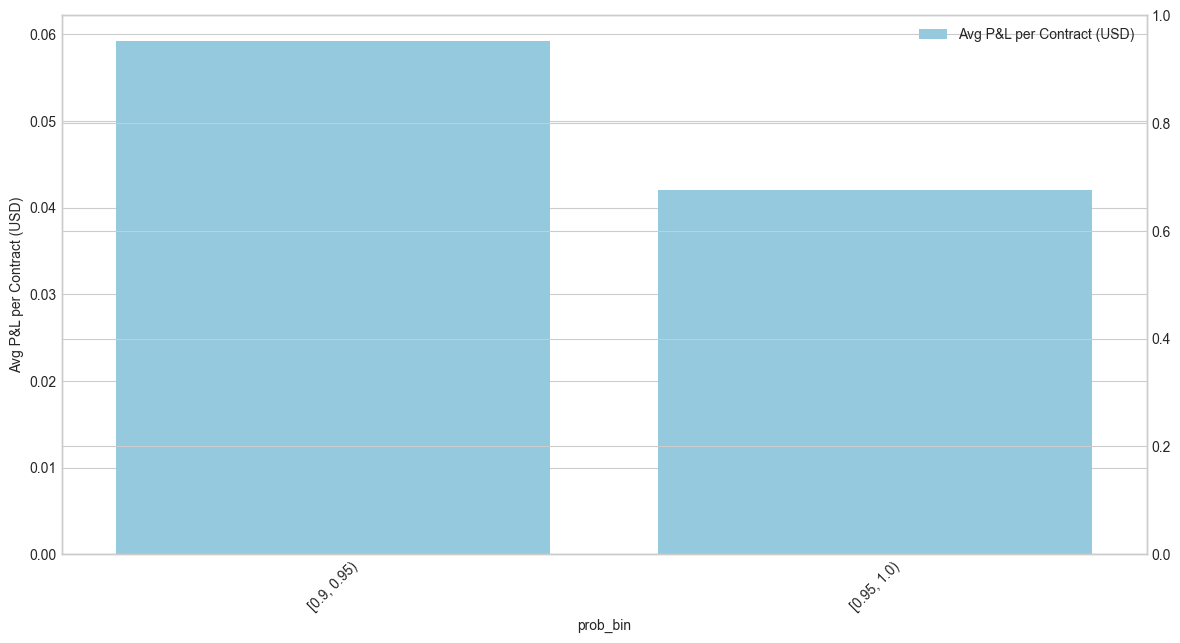

In [26]:
# Cell 7: Analysis by Predicted Probability (and Contracts Traded)

if not all_trades_df.empty and 'predicted_prob_yes' in all_trades_df.columns:
    logger_eda_live.info("\n--- Predicted Probability Analysis (Live Backtest) ---")
    all_trades_df['predicted_prob_yes'] = pd.to_numeric(all_trades_df['predicted_prob_yes'], errors='coerce')

    # Distribution of predicted probabilities for BUY_YES trades
    buy_yes_trades = all_trades_df[all_trades_df['action'] == 'BUY_YES'].copy()
    if not buy_yes_trades.empty and 'predicted_prob_yes' in buy_yes_trades.columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(buy_yes_trades['predicted_prob_yes'], bins=20, kde=False, color='skyblue')
        plt.title('Distribution of P(Yes) for BUY_YES Trades (Live Backtest)')
        plt.xlabel('Predicted P(Yes)'); plt.ylabel('Frequency'); plt.show()
    else: logger_eda_live.info("No BUY_YES trades or 'predicted_prob_yes' column missing.")

    # Distribution of predicted P(No) for BUY_NO trades
    buy_no_trades = all_trades_df[all_trades_df['action'] == 'BUY_NO'].copy()
    if not buy_no_trades.empty and 'predicted_prob_yes' in buy_no_trades.columns:
        buy_no_trades['predicted_prob_no'] = 1 - buy_no_trades['predicted_prob_yes']
        plt.figure(figsize=(10, 5))
        sns.histplot(buy_no_trades['predicted_prob_no'], bins=20, kde=False, color='salmon')
        plt.title('Distribution of P(No) for BUY_NO Trades (Live Backtest)')
        plt.xlabel('Predicted P(No)'); plt.ylabel('Frequency'); plt.show()
    else: logger_eda_live.info("No BUY_NO trades or 'predicted_prob_yes' column missing.")
        
    temp_df_for_confidence = all_trades_df.copy()
    def calculate_confidence(row):
        if pd.isna(row['predicted_prob_yes']): return np.nan
        if row['action'] == 'BUY_YES': return row['predicted_prob_yes']
        elif row['action'] == 'BUY_NO': return 1 - row['predicted_prob_yes']
        return np.nan
    temp_df_for_confidence['confidence_in_bet_direction'] = temp_df_for_confidence.apply(calculate_confidence, axis=1)
    
    if 'confidence_in_bet_direction' in temp_df_for_confidence.columns and not temp_df_for_confidence['confidence_in_bet_direction'].isnull().all():
        # Use actual thresholds from config for binning if possible, or wider bins
        min_threshold = min(live_cfg.PROBABILITY_THRESHOLD_YES, live_cfg.PROBABILITY_THRESHOLD_NO)
        prob_bins = np.arange(min_threshold, 1.01, 0.05) 
        if len(prob_bins) < 2: prob_bins = np.arange(0.5, 1.01, 0.05) # Fallback if thresholds are too high/close
            
        temp_df_for_confidence['prob_bin'] = pd.cut(temp_df_for_confidence['confidence_in_bet_direction'], 
                                                    bins=prob_bins, right=False, include_lowest=True) 
    
        binned_analysis = temp_df_for_confidence.groupby('prob_bin', observed=False).agg(
            num_trades=('market_ticker', 'size'),
            total_contracts=('contracts_traded', 'sum'),
            total_pnl_cents=('pnl_cents', 'sum'),
            avg_pnl_per_trade_cents=('pnl_cents', 'mean'),
            avg_contracts_per_trade=('contracts_traded', 'mean'),
            win_rate=('pnl_cents', lambda x: (x > 0).sum() / x.count() if x.count() > 0 else 0)
        ).reset_index()
        binned_analysis['avg_pnl_per_trade_usd'] = binned_analysis['avg_pnl_per_trade_cents'] / 100.0
        binned_analysis['total_pnl_usd'] = binned_analysis['total_pnl_cents'] / 100.0
        binned_analysis['avg_pnl_per_contract_usd'] = (binned_analysis['total_pnl_cents'] / binned_analysis['total_contracts']) / 100.0
        
        logger_eda_live.info("\n--- Analysis by Binned Model Confidence (Live Backtest) ---")
        print("Performance by Model Confidence Bins:")
        display(binned_analysis[['prob_bin', 'num_trades', 'total_contracts', 'total_pnl_usd', 
                                 'avg_pnl_per_trade_usd', 'avg_pnl_per_contract_usd', 
                                 'avg_contracts_per_trade', 'win_rate']])
        
        # Plot avg contracts and avg P&L per contract
        fig, ax1 = plt.subplots(figsize=(14,7))
        sns.barplot(data=binned_analysis, x='prob_bin', y='avg_pnl_per_contract_usd', color='skyblue', ax=ax1, label='Avg P&L per Contract (USD)')
        ax1.set_ylabel('Avg P&L per Contract (USD)')
        ax1.tick_params(axis='x', rotation=45)
        
        ax2 = ax1.twinx()
        sns.lineplot(data=binned_analysis, x='prob_bin', y='avg_contracts_per_trade', color='red', marker='o', ax=ax2, label='Avg Contracts Traded')
        ax2.set_ylabel('Avg Contracts Traded')
        
        plt.title('Avg P&L per Contract & Avg Contracts Traded by Confidence Bin')
        fig.tight_layout()
        fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
        plt.show()

    else: logger_eda_live.info("Could not perform binned probability analysis.")
else: logger_eda_live.warning("Cannot analyze by predicted probability: DataFrame empty or required columns missing.")

2025-05-23 15:56:04,450 - INFO - eda_live_backtest_logs - 
--- Performance by Time to Resolution (Live Backtest) ---
2025-05-23 15:56:04,459 - INFO - eda_live_backtest_logs - 
--- P&L and Win Rate by Time to Resolution Bin (Live Backtest) ---


Performance by Time to Resolution Bins:


,time_to_res_bin,num_trades,total_contracts,total_pnl_usd,avg_pnl_per_trade_usd,avg_pnl_per_contract_usd,avg_contracts_per_trade,win_rate
0,0-0min,0,0,0.00,NaN,NaN,NaN,0.000000
1,1-2min,7,170,7.92,1.131429,0.046588,24.285714,1.000000
2,3-4min,17,272,14.89,0.875882,0.054743,16.000000,1.000000
3,5-9min,60,962,49.04,0.817333,0.050977,16.033333,1.000000
4,10-14min,56,818,42.67,0.761964,0.052164,14.607143,1.000000
5,15-29min,154,2099,97.50,0.633117,0.046451,13.629870,0.980519
6,30-59min,1,12,0.96,0.960000,0.080000,12.000000,1.000000


/var/folders/43/br9zl9l149d3rb94gdkr1wsm0000gn/T/ipykernel_6469/1140020985.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=time_binned_analysis, x='time_to_res_bin', y='avg_pnl_per_contract_usd', palette="viridis_r", ax=ax1, label='Avg P&L per Contract (USD)')


ValueError: keyword ha is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

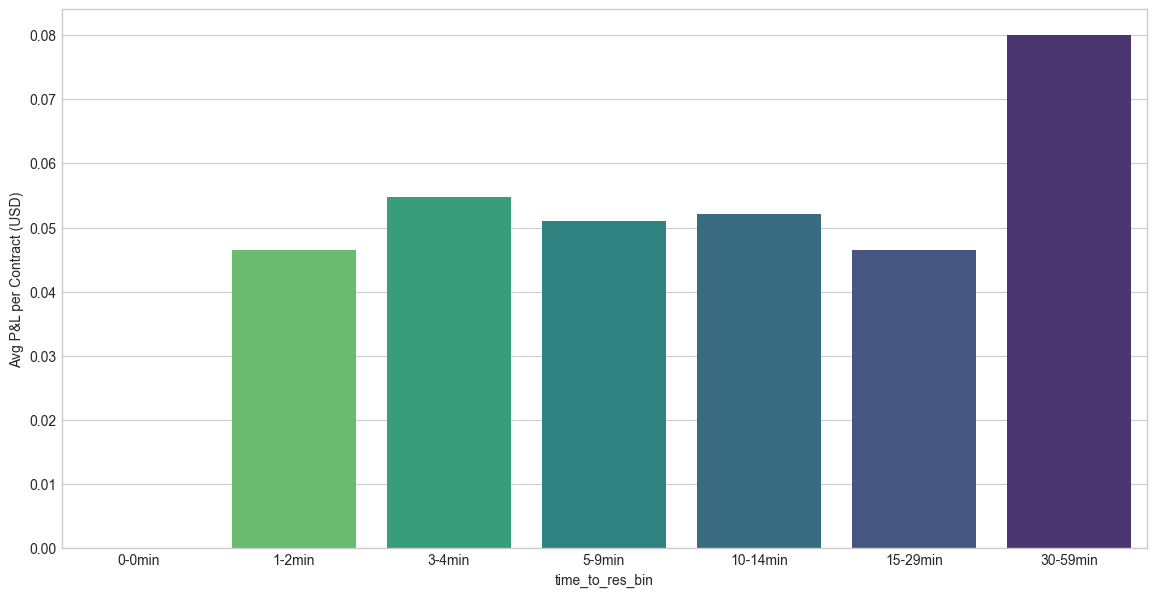

In [17]:
# Cell 8: Analysis by `time_to_resolution_minutes` (Updated for Contracts)

if not all_trades_df.empty and 'time_to_resolution_minutes' in all_trades_df.columns:
    logger_eda_live.info("\n--- Performance by Time to Resolution (Live Backtest) ---")
    all_trades_df['time_to_resolution_minutes'] = pd.to_numeric(all_trades_df['time_to_resolution_minutes'], errors='coerce')
    
    feature_lag_windows = [1, 3, 5, 10, 15, 30] 
    time_bins = sorted(list(set([0] + feature_lag_windows + [60]))) 
    time_labels = []
    for i in range(len(time_bins) -1):
        if time_bins[i+1] == 60 and time_bins[i] == 30: time_labels.append(f"{time_bins[i]}-{time_bins[i+1]-1}min")
        elif i == len(time_bins) - 2 : time_labels.append(f"{time_bins[i]}+ min")
        else: time_labels.append(f"{time_bins[i]}-{time_bins[i+1]-1}min")

    max_time_to_res = all_trades_df['time_to_resolution_minutes'].max()
    if max_time_to_res > 60:
        extended_bins = sorted(list(set(time_bins + [120, 240, 720, int(max_time_to_res // 60)*60 + 60, np.inf])))
        time_bins = [b for b in extended_bins if b <= max_time_to_res + 1] # Ensure bins don't exceed max time much
        if time_bins[-1] != np.inf and max_time_to_res > time_bins[-1]: time_bins.append(np.inf)
        time_bins = sorted(list(set(time_bins))) # remove duplicates and sort

        time_labels = []
        for i in range(len(time_bins) -1):
            if time_bins[i+1] == np.inf: time_labels.append(f"{int(time_bins[i])}+ min")
            else: time_labels.append(f"{int(time_bins[i])}-{int(time_bins[i+1]-1)}min")

    all_trades_df['time_to_res_bin'] = pd.cut(all_trades_df['time_to_resolution_minutes'], 
                                              bins=time_bins, labels=time_labels, 
                                              right=False, include_lowest=True)

    time_binned_analysis = all_trades_df.groupby('time_to_res_bin', observed=False).agg(
        num_trades=('market_ticker', 'size'),
        total_contracts=('contracts_traded', 'sum'),
        total_pnl_cents=('pnl_cents', 'sum'),
        avg_pnl_per_trade_cents=('pnl_cents', 'mean'),
        avg_contracts_per_trade=('contracts_traded', 'mean'),
        win_rate=('pnl_cents', lambda x: (x > 0).sum() / x.count() if x.count() > 0 else 0)
    ).reset_index()
    time_binned_analysis['avg_pnl_per_trade_usd'] = time_binned_analysis['avg_pnl_per_trade_cents'] / 100.0
    time_binned_analysis['total_pnl_usd'] = time_binned_analysis['total_pnl_cents'] / 100.0
    time_binned_analysis['avg_pnl_per_contract_usd'] = (time_binned_analysis['total_pnl_cents'] / time_binned_analysis['total_contracts']) / 100.0
    
    logger_eda_live.info("\n--- P&L and Win Rate by Time to Resolution Bin (Live Backtest) ---")
    print("Performance by Time to Resolution Bins:")
    display(time_binned_analysis[['time_to_res_bin', 'num_trades', 'total_contracts', 'total_pnl_usd', 
                                  'avg_pnl_per_trade_usd','avg_pnl_per_contract_usd', 
                                  'avg_contracts_per_trade', 'win_rate']])

    fig, ax1 = plt.subplots(figsize=(14, 7))
    sns.barplot(data=time_binned_analysis, x='time_to_res_bin', y='avg_pnl_per_contract_usd', palette="viridis_r", ax=ax1, label='Avg P&L per Contract (USD)')
    ax1.set_ylabel('Avg P&L per Contract (USD)')
    ax1.tick_params(axis='x', rotation=45, ha='right')
    
    ax2 = ax1.twinx()
    sns.lineplot(data=time_binned_analysis, x='time_to_res_bin', y='avg_contracts_per_trade', color='coral', marker='o', ax=ax2, label='Avg Contracts Traded')
    ax2.set_ylabel('Avg Contracts Traded')
    
    plt.title('Avg P&L per Contract & Avg Contracts by Time to Resolution Bin')
    fig.tight_layout(); fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.show()
else:
    logger_eda_live.warning("Cannot analyze by time to resolution: DataFrame empty or required columns missing.")

2025-05-23 15:56:15,128 - INFO - eda_live_backtest_logs - 
--- Misclassification Analysis (Live Backtest) ---
2025-05-23 15:56:15,131 - INFO - eda_live_backtest_logs - Total misclassified trades (0.5 prob threshold): 3 out of 295
2025-05-23 15:56:15,132 - INFO - eda_live_backtest_logs - False Positives (Predicted YES, was NO): 0
2025-05-23 15:56:15,132 - INFO - eda_live_backtest_logs - False Negatives (Predicted NO, was YES): 3


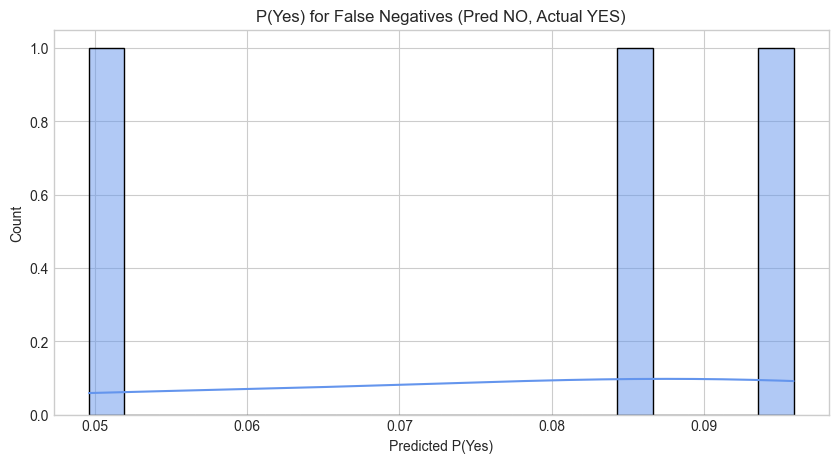

Sample False Negatives (P&L reflects actual contracts traded if BUY_NO was taken):


,market_ticker,decision_timestamp_s,predicted_prob_yes,actual_outcome_target,time_to_resolution_minutes,contracts_traded,pnl_cents
37,KXBTCD-25MAY2019-T106749.99,1747780560,0.0496,1,24.0,2,-190
42,KXBTCD-25MAY2019-T106749.99,1747780920,0.0857,1,18.0,13,-1183
86,KXBTCD-25MAY2118-T108499.99,1747863360,0.0959,1,24.0,12,-1080



Misclassifications by Time to Resolution Bin:


,time_to_res_bin,misclassification_count
0,0-0min,0
1,1-2min,0
2,3-4min,0
3,5-9min,0
4,10-14min,0
5,15-29min,3
6,30-59min,0


In [18]:
# Cell 9: Analysis of Misclassifications

if not all_trades_df.empty and 'predicted_prob_yes' in all_trades_df.columns and 'actual_outcome_target' in all_trades_df.columns:
    logger_eda_live.info("\n--- Misclassification Analysis (Live Backtest) ---")
    
    all_trades_df['simple_prediction'] = (all_trades_df['predicted_prob_yes'] >= 0.5).astype(int)
    misclassified_df = all_trades_df[all_trades_df['simple_prediction'] != all_trades_df['actual_outcome_target']].copy()
    
    if not misclassified_df.empty:
        logger_eda_live.info(f"Total misclassified trades (0.5 prob threshold): {len(misclassified_df)} out of {len(all_trades_df)}")
        fp_df = misclassified_df[(misclassified_df['simple_prediction'] == 1) & (misclassified_df['actual_outcome_target'] == 0)]
        fn_df = misclassified_df[(misclassified_df['simple_prediction'] == 0) & (misclassified_df['actual_outcome_target'] == 1)]
        logger_eda_live.info(f"False Positives (Predicted YES, was NO): {len(fp_df)}")
        logger_eda_live.info(f"False Negatives (Predicted NO, was YES): {len(fn_df)}")

        if not fp_df.empty:
            plt.figure(figsize=(10,5)); sns.histplot(fp_df['predicted_prob_yes'], bins=20, kde=True, color='orangered')
            plt.title('P(Yes) for False Positives (Pred YES, Actual NO)'); plt.xlabel('Predicted P(Yes)'); plt.show()
            print("Sample False Positives (P&L reflects actual contracts traded):")
            display(fp_df[['market_ticker','decision_timestamp_s','predicted_prob_yes','actual_outcome_target','time_to_resolution_minutes','contracts_traded','pnl_cents']].head())
        
        if not fn_df.empty:
            plt.figure(figsize=(10,5)); sns.histplot(fn_df['predicted_prob_yes'], bins=20, kde=True, color='cornflowerblue')
            plt.title('P(Yes) for False Negatives (Pred NO, Actual YES)'); plt.xlabel('Predicted P(Yes)'); plt.show()
            print("Sample False Negatives (P&L reflects actual contracts traded if BUY_NO was taken):")
            display(fn_df[['market_ticker','decision_timestamp_s','predicted_prob_yes','actual_outcome_target','time_to_resolution_minutes','contracts_traded','pnl_cents']].head())
            
        if 'time_to_res_bin' in misclassified_df.columns: # Ensure bin created in cell 8
            misclassified_by_time = misclassified_df.groupby('time_to_res_bin', observed=False).size().reset_index(name='misclassification_count')
            print("\nMisclassifications by Time to Resolution Bin:"); display(misclassified_by_time)
    else: logger_eda_live.info("No misclassified trades (0.5 prob) or required columns missing.")
else: logger_eda_live.warning("Cannot perform misclassification analysis: DataFrame empty or required columns missing.")

2025-05-23 15:56:39,503 - INFO - eda_live_backtest_logs - 
--- Performance by Individual Kalshi Market (Live Backtest) ---



Top Performing Markets (by total P&L USD):


,market_ticker,num_trades_on_market,total_contracts_market,total_pnl_usd_market,win_rate_market,avg_pnl_per_contract_usd,avg_pred_prob_yes,avg_kelly_f_star
20,KXBTCD-25MAY2119-T108249.99,18,422,16.88,1.0,0.040000,0.963278,0.082011
32,KXBTCD-25MAY2122-T109499.99,14,283,14.05,1.0,0.049647,0.949536,0.062436
26,KXBTCD-25MAY2120-T109249.99,10,184,10.68,1.0,0.058043,0.941450,0.059600
41,KXBTCD-25MAY2219-T110999.99,14,183,10.57,1.0,0.057760,0.938614,0.037850
25,KXBTCD-25MAY2120-T108999.99,12,197,10.20,1.0,0.051777,0.950292,0.053983
21,KXBTCD-25MAY2119-T108499.99,15,204,10.19,1.0,0.049951,0.950400,0.047787
7,KXBTCD-25MAY2019-T105999.99,15,238,10.00,1.0,0.042017,0.959860,0.060033
49,KXBTCD-25MAY2300-T110999.99,10,135,7.27,1.0,0.053852,0.938020,0.037350
43,KXBTCD-25MAY2219-T111499.99,9,103,7.21,1.0,0.070000,0.067678,0.033000
17,KXBTCD-25MAY2118-T108249.99,9,143,6.91,1.0,0.048322,0.951667,0.057800



Worst Performing Markets (by total P&L USD):


,market_ticker,num_trades_on_market,total_contracts_market,total_pnl_usd_market,win_rate_market,avg_pnl_per_contract_usd,avg_pred_prob_yes,avg_kelly_f_star
2,KXBTCD-25MAY2015-T106499.99,4,21,1.54,1.0,0.073333,0.076025,0.020125
15,KXBTCD-25MAY2118-T107749.99,1,26,1.30,1.0,0.050000,0.954600,0.092100
39,KXBTCD-25MAY2123-T110249.99,1,10,1.00,1.0,0.100000,0.903000,0.030100
42,KXBTCD-25MAY2219-T111249.99,1,14,0.98,1.0,0.070000,0.067300,0.038900
3,KXBTCD-25MAY2016-T106499.99,3,21,0.84,1.0,0.040000,0.961167,0.029200
13,KXBTCD-25MAY2117-T108999.99,3,10,0.80,1.0,0.080000,0.079033,0.012100
27,KXBTCD-25MAY2120-T109499.99,1,10,0.80,1.0,0.080000,0.922600,0.033000
11,KXBTCD-25MAY2019-T106999.99,1,2,0.16,1.0,0.080000,0.079200,0.010400
18,KXBTCD-25MAY2118-T108499.99,1,12,-10.80,0.0,-0.900000,0.095900,0.040900
10,KXBTCD-25MAY2019-T106749.99,4,50,-11.43,0.5,-0.228600,0.503400,0.045650


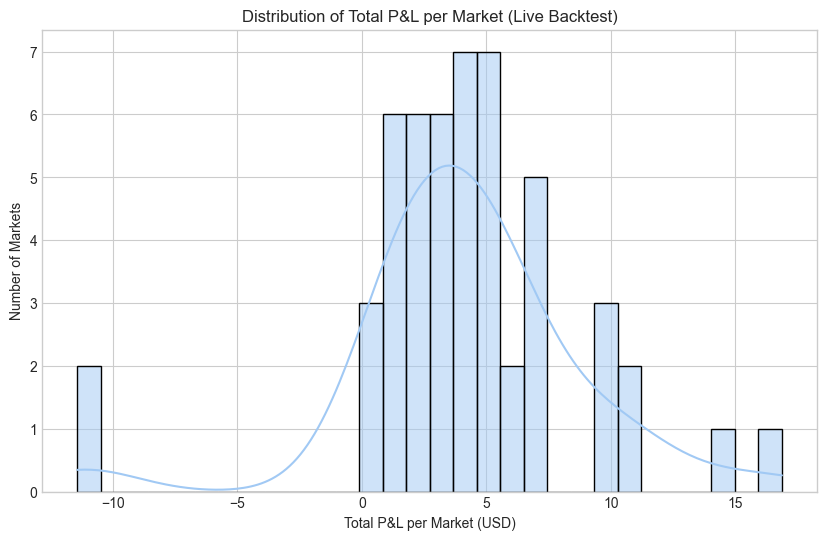

In [19]:
# Cell 10: Market-Level Aggregation (Updated for Contracts)

if not all_trades_df.empty and 'market_ticker' in all_trades_df.columns:
    logger_eda_live.info("\n--- Performance by Individual Kalshi Market (Live Backtest) ---")
    
    market_level_performance = all_trades_df.groupby('market_ticker').agg(
        num_trades_on_market=('action', 'count'),
        total_contracts_market=('contracts_traded', 'sum'),
        total_pnl_cents_market=('pnl_cents', 'sum'),
        avg_pnl_cents_per_trade_market=('pnl_cents', 'mean'),
        win_trades_market=('pnl_cents', lambda x: (x > 0).sum()),
        avg_pred_prob_yes = ('predicted_prob_yes', 'mean'),
        avg_kelly_f_star = ('kelly_fraction_f_star', 'mean') # If Kelly was used
    ).reset_index()

    market_level_performance['total_pnl_usd_market'] = market_level_performance['total_pnl_cents_market'] / 100.0
    market_level_performance['win_rate_market'] = market_level_performance.apply(
        lambda row: row['win_trades_market'] / row['num_trades_on_market'] if row['num_trades_on_market'] > 0 else 0, axis=1
    )
    market_level_performance['avg_pnl_per_contract_usd'] = (market_level_performance['total_pnl_cents_market'] / market_level_performance['total_contracts_market']) / 100.0
    
    market_level_performance.sort_values(by='total_pnl_usd_market', ascending=False, inplace=True)
    
    cols_to_display = ['market_ticker', 'num_trades_on_market', 'total_contracts_market', 'total_pnl_usd_market', 'win_rate_market', 'avg_pnl_per_contract_usd', 'avg_pred_prob_yes']
    if 'avg_kelly_f_star' in market_level_performance.columns:
        cols_to_display.append('avg_kelly_f_star')
        
    print("\nTop Performing Markets (by total P&L USD):")
    display(market_level_performance[cols_to_display].head(10))
    
    print("\nWorst Performing Markets (by total P&L USD):")
    display(market_level_performance[cols_to_display].tail(10))

    plt.figure(figsize=(10, 6))
    sns.histplot(market_level_performance['total_pnl_usd_market'], bins=30, kde=True)
    plt.title('Distribution of Total P&L per Market (Live Backtest)')
    plt.xlabel('Total P&L per Market (USD)'); plt.ylabel('Number of Markets'); plt.grid(True); plt.show()
else:
    logger_eda_live.warning("Cannot perform market-level aggregation: DataFrame empty or 'market_ticker' column missing.")

2025-05-23 15:57:13,325 - INFO - eda_live_backtest_logs - 
--- Kelly Criterion Specific Analysis (Live Backtest) ---


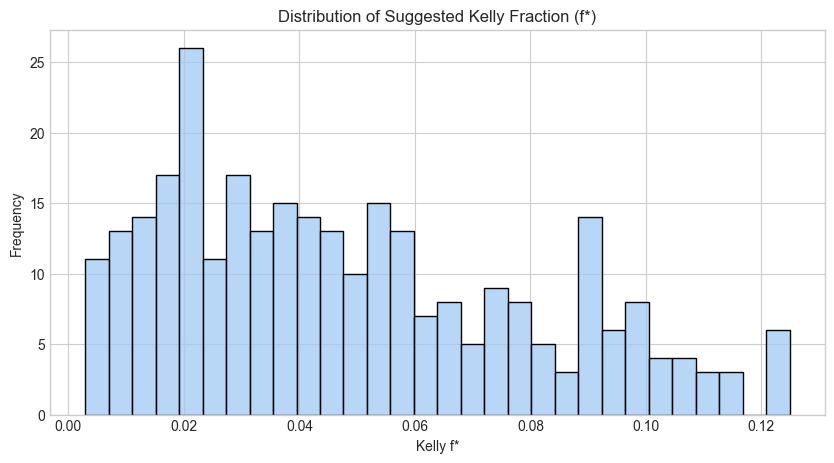

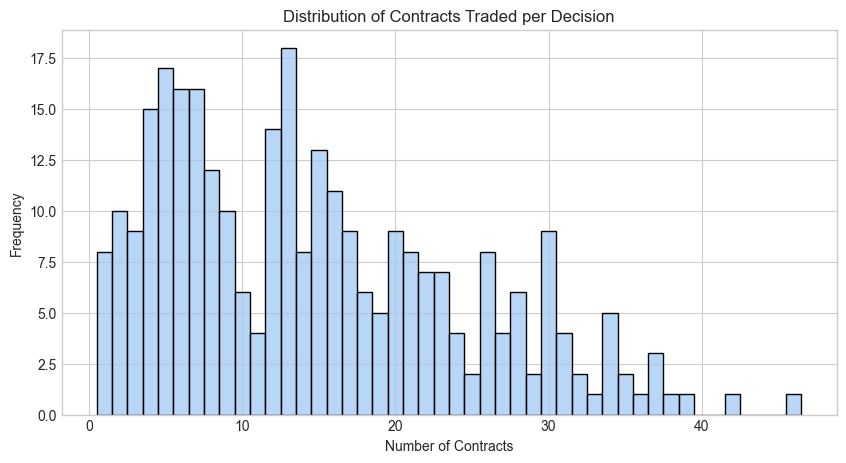

2025-05-23 15:57:13,491 - INFO - eda_live_backtest_logs - Contracts Traded Stats:
count    295.000000
mean      14.688136
std        9.747023
min        1.000000
25%        6.000000
50%       13.000000
75%       21.000000
max       46.000000


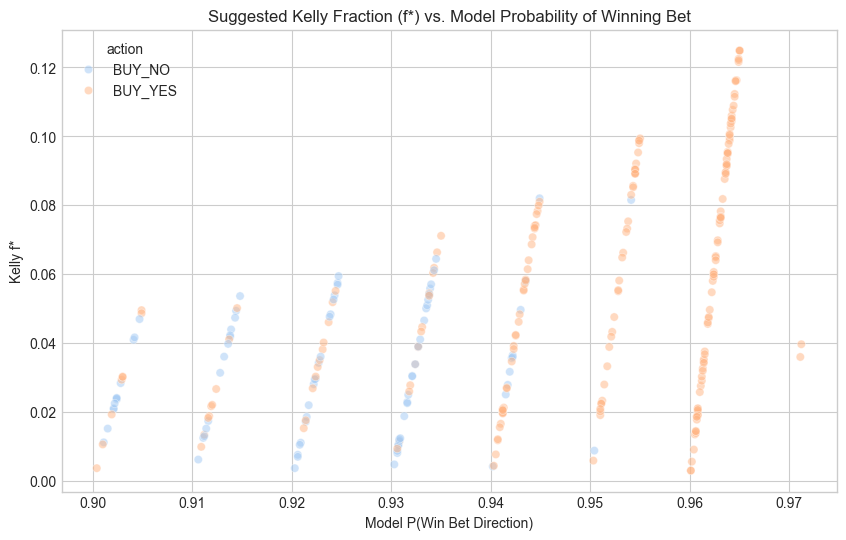

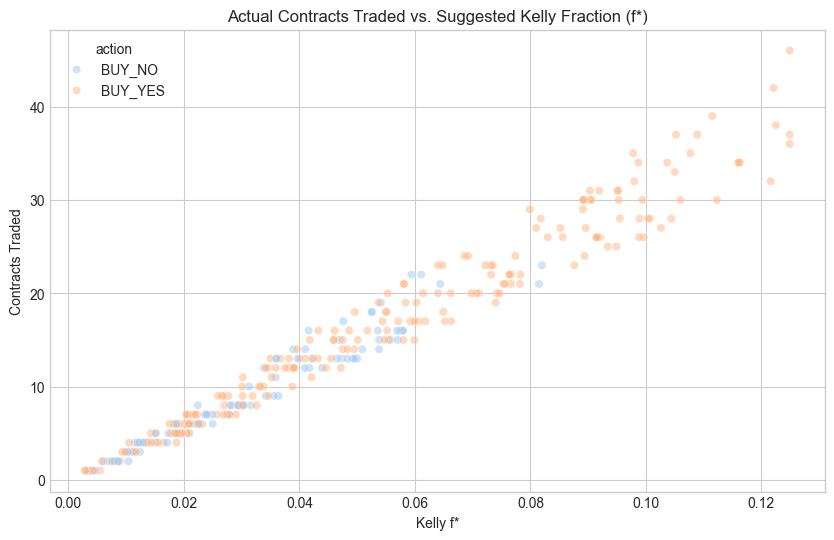

NameError: name 'live_cfg' is not defined

In [ ]:
# Cell 11: Kelly Criterion Specific Analysis

if not all_trades_df.empty and 'kelly_fraction_f_star' in all_trades_df.columns:
    logger_eda_live.info("\n--- Kelly Criterion Specific Analysis (Live Backtest) ---")
    
    kelly_trades_df = all_trades_df[all_trades_df['contracts_traded'] > 0].copy() # Only trades where a bet was made
    
    if not kelly_trades_df.empty:
        # Distribution of Kelly Fraction (f*) suggested by the formula (before Kelly_Fraction multiplier)
        plt.figure(figsize=(10,5))
        sns.histplot(kelly_trades_df['kelly_fraction_f_star'], bins=30, kde=False)
        plt.title('Distribution of Suggested Kelly Fraction (f*)')
        plt.xlabel('Kelly f*'); plt.ylabel('Frequency'); plt.show()

        # Distribution of actual contracts traded
        plt.figure(figsize=(10,5))
        sns.histplot(kelly_trades_df['contracts_traded'], discrete=True) # discrete=True for integer counts
        plt.title('Distribution of Contracts Traded per Decision')
        plt.xlabel('Number of Contracts'); plt.ylabel('Frequency'); plt.show()
        logger_eda_live.info(f"Contracts Traded Stats:\n{kelly_trades_df['contracts_traded'].describe().to_string()}")


        # Scatter plot: Kelly f* vs. P(Win)
        plt.figure(figsize=(10,6))
        # For BUY_YES, P(Win) = predicted_prob_yes. For BUY_NO, P(Win) = 1 - predicted_prob_yes
        kelly_trades_df['prob_of_winning_bet_direction'] = kelly_trades_df.apply(
            lambda row: row['predicted_prob_yes'] if row['action'] == 'BUY_YES' else (1 - row['predicted_prob_yes']), axis=1
        )
        sns.scatterplot(data=kelly_trades_df, x='prob_of_winning_bet_direction', y='kelly_fraction_f_star', hue='action', alpha=0.5)
        plt.title('Suggested Kelly Fraction (f*) vs. Model Probability of Winning Bet')
        plt.xlabel('Model P(Win Bet Direction)'); plt.ylabel('Kelly f*'); plt.grid(True); plt.show()
        
        # Scatter plot: Contracts Traded vs. Kelly f*
        plt.figure(figsize=(10,6))
        sns.scatterplot(data=kelly_trades_df, x='kelly_fraction_f_star', y='contracts_traded', hue='action', alpha=0.5)
        plt.title('Actual Contracts Traded vs. Suggested Kelly Fraction (f*)')
        plt.xlabel('Kelly f*'); plt.ylabel('Contracts Traded'); plt.grid(True); plt.show()
        
        # Check if Max % Capital per trade was a binding constraint
        if 'capital_to_risk_cents' in kelly_trades_df.columns and 'current_capital_before_trade_cents' in kelly_trades_df.columns:
            kelly_trades_df['pct_capital_risked_actual'] = (kelly_trades_df['trade_value_cents'] / kelly_trades_df['current_capital_before_trade_cents']) * 100
            kelly_trades_df['pct_capital_risked_target_kelly'] = kelly_trades_df['kelly_fraction_f_star'] * live_cfg.KELLY_FRACTION * 100
            
            plt.figure(figsize=(10,5))
            sns.histplot(kelly_trades_df['pct_capital_risked_actual'], bins=30, kde=False)
            plt.axvline(live_cfg.MAX_PCT_CAPITAL_PER_TRADE * 100, color='r', linestyle='--', label=f'Max % Cap Config: {live_cfg.MAX_PCT_CAPITAL_PER_TRADE*100:.1f}%')
            plt.title('Distribution of Actual % Capital Risked per Trade')
            plt.xlabel('% Capital Risked'); plt.ylabel('Frequency'); plt.legend(); plt.show()
            
            hit_max_cap_pct_limit = kelly_trades_df[
                (kelly_trades_df['pct_capital_risked_actual'] >= live_cfg.MAX_PCT_CAPITAL_PER_TRADE * 100 - 0.1) & # Check if close to cap
                (kelly_trades_df['pct_capital_risked_target_kelly'] > live_cfg.MAX_PCT_CAPITAL_PER_TRADE * 100)     # And Kelly wanted more
            ]
            logger_eda_live.info(f"{len(hit_max_cap_pct_limit)} trades potentially capped by MAX_PCT_CAPITAL_PER_TRADE.")

    else:
        logger_eda_live.info("No trades with Kelly sizing information found for detailed analysis.")
else:
    logger_eda_live.warning("Kelly criterion columns not found in trade logs. Skipping Kelly-specific EDA.")